# 读取路径数据和再分析数据

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from geopy.distance import great_circle

import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
# from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

# 预测24小时后
pre_seq = 4
# 批训练数量
batch_size = 128
# 训练迭代次数
epochs = 128
# 设置验证loss，用于保存模型
min_val_loss = 100
# 保存模型
model_name = 'torch_CLIPER_u_v_2DCNN_multi_pressure(4)_multi_time_split_fuse_attention-time-24h.pkl'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train = pd.read_csv('../../CMA_Chinese_Academy_of_Sciences/CMA_train_'+str(pre_seq*6)+'h.csv', header=None)
test= pd.read_csv('../../CMA_Chinese_Academy_of_Sciences/CMA_test_'+str(pre_seq*6)+'h.csv', header=None)

In [3]:
train.shape, test.shape

((8406, 101), (2747, 101))

In [4]:
CLIPER_feature =  pd.concat((train, test), axis=0)
CLIPER_feature.reset_index(drop=True, inplace=True)

In [5]:
X_wide_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_wide = X_wide_scaler.fit_transform(CLIPER_feature.iloc[:, 5:])
X_wide_train = X_wide[0: train.shape[0], :]

y = y_scaler.fit_transform(CLIPER_feature.loc[:, 3].values.reshape(-1, 1))
y_train = y[0: train.shape[0], :]

In [6]:
# 获取是否提前（0为当前，1表示前6小时，2表示前12小时）
ahead_times = [0,1,2,3]
# 所需要的等压面
pressures = [1000, 750, 500, 250]

# 再分析数据
sequential_reanalysis_u_list = []
# 再分析数据
reanalysis_u_test_dict = {}
# 归一化Scaler
X_deep_u_scaler_dict = {}

# 再分析数据
sequential_reanalysis_v_list = []
# 再分析数据
reanalysis_v_test_dict = {}
# 归一化Scaler
X_deep_v_scaler_dict = {}

In [7]:
# 再分析类型
reanalysis_type = 'u'
for ahead_time in ahead_times:
    # 再分析数据
    reanalysis_list = []
    for pressure in pressures:
        # 根据时间段读取不同再分析数据
        folder = None
        if ahead_time == 0:
            folder = reanalysis_type
        else:
            folder = reanalysis_type + '_' + str(ahead_time*6)
        # 读取再分析文件
        train_reanalysis_csv = pd.read_csv('../../../CMA_deep_learning/CMA_Reanalysis/'+folder+'/'+reanalysis_type+str(pressure)+'_train_31_31.csv', header=None)
        test_reanalysis_csv = pd.read_csv('../../../CMA_deep_learning/CMA_Reanalysis/'+folder+'/'+reanalysis_type+str(pressure)+'_test_31_31.csv', header=None)
        # 根据台风记录ID，选出需要提取再分析数据
        train_reanalysis = train_reanalysis_csv[train_reanalysis_csv[0].isin(train[0].unique())]
        test_reanalysis = test_reanalysis_csv[test_reanalysis_csv[0].isin(test[0].unique())]
        reanalysis_u_test_dict[reanalysis_type+str(pressure)+str(ahead_time)] = test_reanalysis # 保存test 用于后面测试
        # 合并训练和测试再分析数据
        reanalysis =  pd.concat((train_reanalysis, test_reanalysis), axis=0)
        reanalysis.reset_index(drop=True, inplace=True)
        # 归一化
        scaler_name = reanalysis_type +str(pressure) + str(ahead_time)
        X_deep_u_scaler_dict[scaler_name] = MinMaxScaler()
        X_deep = X_deep_u_scaler_dict[scaler_name].fit_transform(reanalysis.loc[:, 5:])
        # 转化为3D CNN的输入形式（batch，长，宽，高，通道）
        X_deep_final = X_deep[0: train.shape[0], :].reshape(-1, 1, 1, 31, 31, 1)
        reanalysis_list.append(X_deep_final)
    # 所在时间，所有等压面合并
    X_deep_temp = np.concatenate(reanalysis_list[:], axis=2)
    print("ahead_time:", ahead_time, X_deep_temp.shape)
    sequential_reanalysis_u_list.append(X_deep_temp)

X_deep_u_train = np.concatenate(sequential_reanalysis_u_list, axis=5)

ahead_time: 0 (8406, 1, 4, 31, 31, 1)
ahead_time: 1 (8406, 1, 4, 31, 31, 1)
ahead_time: 2 (8406, 1, 4, 31, 31, 1)
ahead_time: 3 (8406, 1, 4, 31, 31, 1)


In [8]:
# 再分析类型
reanalysis_type = 'v'
for ahead_time in ahead_times:
    # 再分析数据
    reanalysis_list = []
    for pressure in pressures:
        # 根据时间段读取不同再分析数据
        folder = None
        if ahead_time == 0:
            folder = reanalysis_type
        else:
            folder = reanalysis_type + '_' + str(ahead_time*6)
        # 读取再分析文件
        train_reanalysis_csv = pd.read_csv('../../../CMA_deep_learning/CMA_Reanalysis/'+folder+'/'+reanalysis_type+str(pressure)+'_train_31_31.csv', header=None)
        test_reanalysis_csv = pd.read_csv('../../../CMA_deep_learning/CMA_Reanalysis/'+folder+'/'+reanalysis_type+str(pressure)+'_test_31_31.csv', header=None)
        # 根据台风记录ID，选出需要提取再分析数据
        train_reanalysis = train_reanalysis_csv[train_reanalysis_csv[0].isin(train[0].unique())]
        test_reanalysis = test_reanalysis_csv[test_reanalysis_csv[0].isin(test[0].unique())]
        reanalysis_v_test_dict[reanalysis_type+str(pressure)+str(ahead_time)] = test_reanalysis # 保存test 用于后面测试
        # 合并训练和测试再分析数据
        reanalysis =  pd.concat((train_reanalysis, test_reanalysis), axis=0)
        reanalysis.reset_index(drop=True, inplace=True)
        # 归一化
        scaler_name = reanalysis_type +str(pressure) + str(ahead_time)
        X_deep_v_scaler_dict[scaler_name] = MinMaxScaler()
        X_deep = X_deep_v_scaler_dict[scaler_name].fit_transform(reanalysis.loc[:, 5:])
        # 转化为3D CNN的输入形式（batch，长，宽，高，通道）
        X_deep_final = X_deep[0: train.shape[0], :].reshape(-1, 1, 1, 31, 31, 1)
        reanalysis_list.append(X_deep_final)
    # 所在时间，所有等压面合并
    X_deep_temp = np.concatenate(reanalysis_list[:], axis=2)
    print("ahead_time:", ahead_time, X_deep_temp.shape)
    sequential_reanalysis_v_list.append(X_deep_temp)

X_deep_v_train = np.concatenate(sequential_reanalysis_v_list, axis=5)

ahead_time: 0 (8406, 1, 4, 31, 31, 1)
ahead_time: 1 (8406, 1, 4, 31, 31, 1)
ahead_time: 2 (8406, 1, 4, 31, 31, 1)
ahead_time: 3 (8406, 1, 4, 31, 31, 1)


In [9]:
X_deep_train = np.concatenate((X_deep_u_train, X_deep_v_train), axis=1)

In [10]:
X_wide_train.shape, X_deep_train.shape

((8406, 96), (8406, 2, 4, 31, 31, 4))

# 划分训练集、验证集

In [11]:
class TrainLoader(Data.Dataset):
    def __init__(self, X_wide_train, X_deep_train, y_train):
        self.X_wide_train = X_wide_train
        self.X_deep_train = X_deep_train
        self.y_train = y_train
        
    def __getitem__(self, index):
        return [self.X_wide_train[index], self.X_deep_train[index]], self.y_train[index]
    
    def __len__(self):
        return len(self.X_wide_train)

In [12]:
full_train_index = [*range(0, len(X_wide_train))]

train_index, val_index, _, _, = train_test_split(full_train_index,full_train_index,test_size=0.1)

In [13]:
len(train_index), len(val_index)

(7565, 841)

In [14]:
train_dataset = torch.utils.data.DataLoader(
    TrainLoader(X_wide_train[train_index], X_deep_train[train_index], y_train[train_index]), 
                                                 batch_size=batch_size, shuffle=True)

In [15]:
val_dataset = torch.utils.data.DataLoader(
    TrainLoader(X_wide_train[val_index], X_deep_train[val_index], y_train[val_index]), 
                                                 batch_size=batch_size, shuffle=True)

# 利用pytorch定义wide & deep 模型

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Attention部分
        self.att_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, padding=0),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
        )
        self.att_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, padding=0),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
        )
        self.att_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, padding=0),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
        )
        # cross部分
        self.cross_unit = nn.Parameter(data=torch.ones(len(ahead_times), 6))
        # fuse部分
        self.fuse_unit = nn.Parameter(data=torch.ones(len(ahead_times), 4))
        # deep部分卷积
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=(1, 1))
        self.fc1 = nn.Linear(256 * 3 * 3, 128)
        self.fc2 = nn.Linear(96 + 128 * len(ahead_times), 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, wide, deep):
        seq_list = []
        for i in range(len(ahead_times)):
            
            deep_u = deep[:,0,:,:,:,i]
            deep_v = deep[:,1,:,:,:,i]
            
            # model input
            model_input_u_scaled = deep_u[0,0].cpu().detach().numpy().copy()
            model_input_v_scaled = deep_v[0,0].cpu().detach().numpy().copy()
            
            # split 1
            deep_u = self.pool(F.relu(self.conv1(deep_u))) 
            deep_v = self.pool(F.relu(self.conv1(deep_v)))
            
            # attention input
            atten_input_u_scaled = nn.Upsample(size=[31,31], mode='bilinear', align_corners=True)(deep_u).cpu().detach().numpy().copy()
            atten_input_v_scaled = nn.Upsample(size=[31,31], mode='bilinear', align_corners=True)(deep_v).cpu().detach().numpy().copy()
            
            Atten_v1 = self.att_block_1(deep_v)
            Atten_u1 = self.att_block_1(deep_u)
            
            deep_v = self.att_block_1(deep_v) * deep_v
            deep_u = self.att_block_1(deep_u)* deep_u
            
            # attention input
            atten_output_u_scaled = nn.Upsample(size=[31,31], mode='bilinear', align_corners=True)(deep_u).cpu().detach().numpy().copy()
            atten_output_v_scaled = nn.Upsample(size=[31,31], mode='bilinear', align_corners=True)(deep_v).cpu().detach().numpy().copy()
            
            if i == 0:
                Atten_u1 = nn.Upsample(size=[31,31], mode='bilinear', align_corners=True)(Atten_u1)
                Attent_U = np.mean(Atten_u1[0,].cpu().detach().numpy(), axis=0)
                Atten_v1 = nn.Upsample(size=[31,31], mode='bilinear', align_corners=True)(Atten_v1)
                Attent_V = np.mean(Atten_v1[0,].cpu().detach().numpy(), axis=0)
                
                fig, axs = plt.subplots(2, 2, figsize=(8,7))
                
                # model input
                model_input_u = X_deep_u_scaler_dict["u10000"].inverse_transform(model_input_u_scaled.reshape(-1,31*31)).reshape(31,31)
                im = axs[0,0].imshow(model_input_u)
                fig.colorbar(im, ax=axs[0,0])
                axs[0,0].set_title('Input U')
                
                model_input_v = X_deep_v_scaler_dict["v10000"].inverse_transform(model_input_v_scaled.reshape(-1,31*31)).reshape(31,31)
                im = axs[0,1].imshow(model_input_v)
                fig.colorbar(im, ax=axs[0,1])
                axs[0,1].set_title('Input V')
                
                sns.heatmap(Attent_U, ax=axs[1,0])
                axs[1,0].set_title('Attention Weigh U')
                sns.heatmap(Attent_V, ax=axs[1,1])
                axs[1,1].set_title('Attention Weigh V')
                
                plt.savefig('sa_ploter.pdf', bbox_inches = 'tight', pad_inches = 0)
                
            
            # fuse 1
            time_seq_1 = self.cross_unit[i][0]/(self.cross_unit[i][0]+self.cross_unit[i][1]) * deep_u +\
            self.cross_unit[i][1]/(self.cross_unit[i][0]+self.cross_unit[i][1])  * deep_v
            time_seq_1 = self.pool(F.relu(self.conv2(time_seq_1)))
            time_seq_1 = self.att_block_2(time_seq_1) * time_seq_1
            
            # split 2
            deep_u = self.pool(F.relu(self.conv2(deep_u)))
            deep_u = self.att_block_2(deep_u) * deep_u
            
            deep_v = self.pool(F.relu(self.conv2(deep_v)))
            deep_v = self.att_block_2(deep_v) * deep_v
            
            # fuse 2
            time_seq_2 = self.cross_unit[i][2]/(self.cross_unit[i][2]+self.cross_unit[i][3]) * deep_u +\
            self.cross_unit[i][3]/(self.cross_unit[i][2]+self.cross_unit[i][3]) * deep_v
            time_seq_2 = self.fuse_unit[i][0]/(self.fuse_unit[i][0]+self.fuse_unit[i][1]) * time_seq_1+\
            self.fuse_unit[i][1]/(self.fuse_unit[i][0]+self.fuse_unit[i][1]) * time_seq_2
            time_seq_2 = self.pool(F.relu(self.conv3(time_seq_2)))
            time_seq_2 = self.att_block_3(time_seq_2) * time_seq_2
            
            # split 3
            deep_u = self.pool(F.relu(self.conv3(deep_u)))
            deep_u = self.att_block_3(deep_u) * deep_u
            
            deep_v = self.pool(F.relu(self.conv3(deep_v)))
            deep_v = self.att_block_3(deep_v) * deep_v
            
            # fuse 3
            time_seq = self.cross_unit[i][4]/(self.cross_unit[i][4]+self.cross_unit[i][5]) * deep_u +\
            self.cross_unit[i][5]/(self.cross_unit[i][4]+self.cross_unit[i][5]) * deep_v
            time_seq = self.fuse_unit[i][2]/(self.fuse_unit[i][2]+self.fuse_unit[i][3]) * time_seq_2+\
            self.fuse_unit[i][3]/(self.fuse_unit[i][2]+self.fuse_unit[i][3]) * time_seq
            time_seq = self.att_block_3(time_seq) * time_seq
            
            time_seq = time_seq.view(-1, 256 * 3 * 3)
            time_seq = self.fc1(time_seq)
            seq_list.append(time_seq)
        wide = wide.view(-1, 96)
        wide_n_deep = torch.cat((wide, seq_list[0]),1)
        if len(ahead_times) > 1:
            for i in range(1, len(ahead_times)):
                wide_n_deep = torch.cat((wide_n_deep, seq_list[i]),1)
        wide_n_deep = F.relu(self.fc2(wide_n_deep))
        wide_n_deep = F.relu(self.fc3(wide_n_deep))
        return wide_n_deep

In [17]:
net = Net()
net.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [18]:
final_test_u_list = []
for ahead_time in ahead_times:
    year_test_list = []
    for pressure in pressures:
        scaler_name = 'u' +str(pressure) + str(ahead_time)
        X_deep = reanalysis_u_test_dict[scaler_name][reanalysis_u_test_dict[scaler_name][0].isin(test[0].unique())].loc[:,5:]
        X_deep = X_deep_u_scaler_dict[scaler_name].transform(X_deep)
        X_deep_final = X_deep.reshape(-1, 1, 1, 31, 31, 1)
        year_test_list.append(X_deep_final)
    X_deep_temp = np.concatenate(year_test_list, axis=2)
    final_test_u_list.append(X_deep_temp)
X_deep_u_test = np.concatenate(final_test_u_list, axis=5)

final_test_v_list = []
for ahead_time in ahead_times:
    year_test_list = []
    for pressure in pressures:
        scaler_name = 'v' +str(pressure) + str(ahead_time)
        X_deep = reanalysis_v_test_dict[scaler_name][reanalysis_v_test_dict[scaler_name][0].isin(test[0].unique())].loc[:,5:]
        X_deep = X_deep_v_scaler_dict[scaler_name].transform(X_deep)
        X_deep_final = X_deep.reshape(-1, 1, 1, 31, 31, 1)
        year_test_list.append(X_deep_final)
    X_deep_temp = np.concatenate(year_test_list, axis=2)
    final_test_v_list.append(X_deep_temp)
X_deep_v_test = np.concatenate(final_test_v_list, axis=5)

X_deep_test = np.concatenate((X_deep_u_test, X_deep_v_test), axis=1)

In [19]:
# 100
# 310
# 410
# 780
# 980
# 555

tensor([[0.1290]], device='cuda:0', grad_fn=<ReluBackward0>)

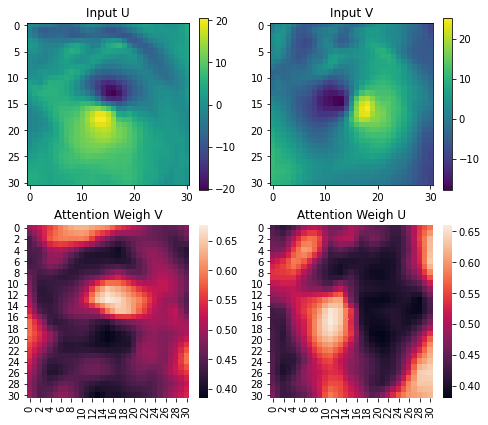

In [20]:
# net.eval()
X_wide = torch.tensor(X_wide_train[0])
X_wide = torch.unsqueeze(X_wide, dim=0).float().cuda()
X_deep = torch.tensor(X_deep_test[555]).float().cuda()
X_deep = torch.unsqueeze(X_deep, dim=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
net(X_wide, X_deep)